In [1]:
import pynucastro as pyna

In [2]:
all_lib = pyna.ReacLibLibrary() + pyna.TabularLibrary(ordering=["ffn", "langanke", "oda"])

In [3]:
filt = pyna.RateFilter(endpoint="s32")
lib = all_lib.filter(filt)

In [4]:
dupes = lib.find_duplicate_links()
rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, pyna.rates.ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    lib.remove_rate(r)

In [5]:
net = pyna.RateCollection(libraries=[lib])

One issue is that some of these nuclei do not have measured masses, so we want to remove them, since we cannot compute the energy release without a mass

In [6]:
nuclei_to_remove = []
for n in net.unique_nuclei:
    if n.mass == None:
        nuclei_to_remove.append(n)

net.remove_nuclei(nuclei_to_remove)

looking to remove O29 ⟶ F29 + e⁻ + 𝜈
looking to remove O29 ⟶ n + F28 + e⁻ + 𝜈
looking to remove O29 ⟶ n + n + F27 + e⁻ + 𝜈
looking to remove O29 + He4 ⟶ n + Ne32
looking to remove O29 + He4 ⟶ p + F32
looking to remove F32 + p ⟶ He4 + O29
looking to remove Ne32 + n ⟶ He4 + O29
looking to remove O30 ⟶ F30 + e⁻ + 𝜈
looking to remove O30 ⟶ n + F29 + e⁻ + 𝜈
looking to remove O30 ⟶ n + n + F28 + e⁻ + 𝜈
looking to remove O31 ⟶ F31 + e⁻ + 𝜈
looking to remove O31 ⟶ n + F30 + e⁻ + 𝜈
looking to remove O31 ⟶ n + n + F29 + e⁻ + 𝜈
looking to remove O32 ⟶ F32 + e⁻ + 𝜈
looking to remove O32 ⟶ n + F31 + e⁻ + 𝜈
looking to remove O32 ⟶ n + n + F30 + e⁻ + 𝜈
looking to remove O32 ⟶ F32 + e⁻ + 𝜈
looking to remove F32 ⟶ Ne32 + e⁻ + 𝜈
looking to remove F32 ⟶ n + Ne31 + e⁻ + 𝜈
looking to remove F32 ⟶ n + n + Ne30 + e⁻ + 𝜈
looking to remove O29 + He4 ⟶ p + F32
looking to remove F32 + p ⟶ n + Ne32
looking to remove F32 + p ⟶ He4 + O29
looking to remove Ne32 + n ⟶ p + F32
looking to remove F32 ⟶ 3 n + Ne29 + e⁻ +

In [7]:
net.summary()

Network summary
---------------
  explicitly carried nuclei: 182
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 1731

  rates explicitly connecting nuclei: 1731
  hidden rates: 0

  reaclib rates: 1621
  tabular rates: 110
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


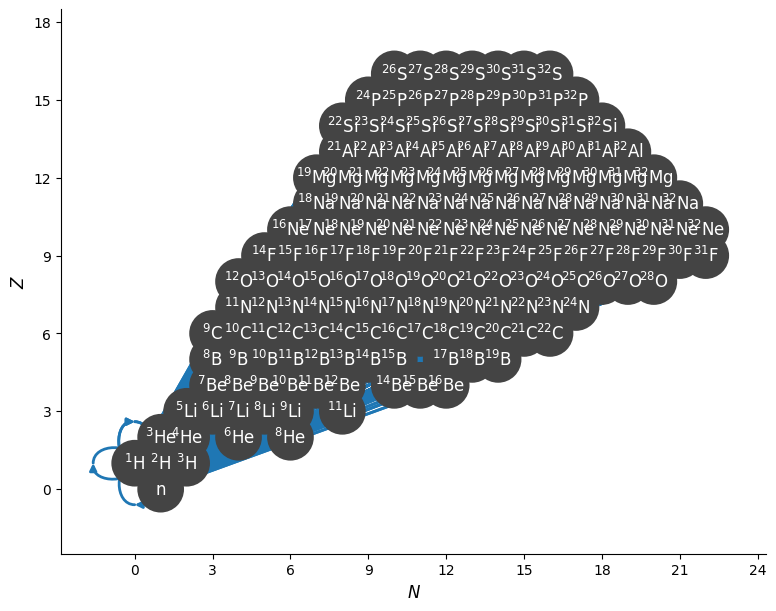

In [8]:
fig = net.plot()

In [9]:
comp = pyna.Composition(net.unique_nuclei)
comp.set_solar_like()
comp.X[pyna.Nucleus("o14")] = 0.02
comp.X[pyna.Nucleus("o15")] = 0.01
comp.normalize()

an issue now is that some of the species are incredibly shortlived, and if we have any abundance there, it will dominate the rate evaluation.  To fix this, we can zero out the abundance for short-lived nuclei.

In [10]:
for n in net.unique_nuclei:
    if n.tau != "stable" and n.tau is not None:
        if n.tau < 1.e-10:
            comp.X[n] = 0.0

comp.normalize()

In [11]:
data = [(comp, 1.e4, 1.e8),
        (comp, 1.e5, 2.e8),
        (comp, 1.e5, 1.e9),
        (comp, 5.e5, 2.e9)]

In [12]:
targets = ["p", "he4",
           "n13", "n14", "n15",
           "c12", "c13",
           "o14", "o15", "o16", "o17", "o18",
           "f18", "f19",
           "ne18", "ne19", "ne20",
           "na22", "na23",
           "mg24", "si28", "s32"]

In [13]:
reduced_net = pyna.drgep(net=net, conds=data, targets=targets, tols=0.9)

/home/zingale/development/pynucastro/pynucastro/reduction/drgep_module.py:72: RuntimeWarning: invalid value encountered in divide
  r_AB = np.abs(p_AB - c_AB) / denom


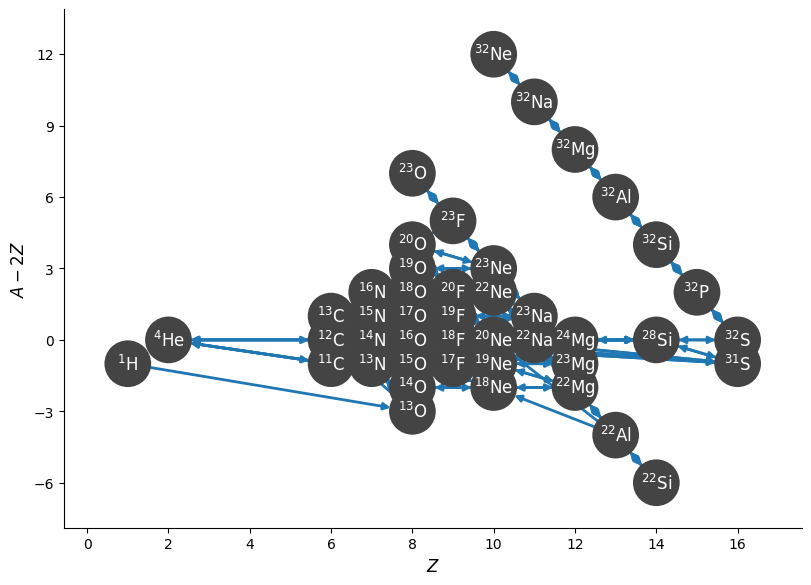

In [16]:
fig = reduced_net.plot(rotated=True, hide_xalpha=True, hide_xp=True)

In [17]:
reduced_net.summary()

Network summary
---------------
  explicitly carried nuclei: 45
  approximated-out nuclei: 0
  inert nuclei (included in carried): 0

  total number of rates: 290

  rates explicitly connecting nuclei: 290
  hidden rates: 0

  reaclib rates: 260
  tabular rates: 30
  approximate rates: 0
  derived rates: 0
  modified rates: 0
  custom rates: 0


We'll create a second set of data that will be used to assess if the network is okay

In [21]:
def err_func(net, validation_data, enuc_reference):
    max_err = 0.0
    for n, (comp, rho, T) in enumerate(validation_data):
        enuc = net.evaluate_energy_generation(rho, T, comp)
        err = max(max_err, abs((enuc - enuc_reference[n]) / enuc_reference[n]))
    return err

In [22]:
threshold = 0.05

In [23]:
enuc_reference = []
for comp, rho, T in data:
    enuc_reference.append(reduced_net.evaluate_energy_generation(rho, T, comp))

In [24]:
reduced_net2 = pyna.sens_analysis(reduced_net, err_func, threshold, args=(data, enuc_reference))

Performing sensitivity analysis...
Pass 1: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 2: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 3: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 4: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 5: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 6: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 7: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 8: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 9: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 10: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 11: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 12: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 13: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 14: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙] 100%
Pass 15: [⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙⊙

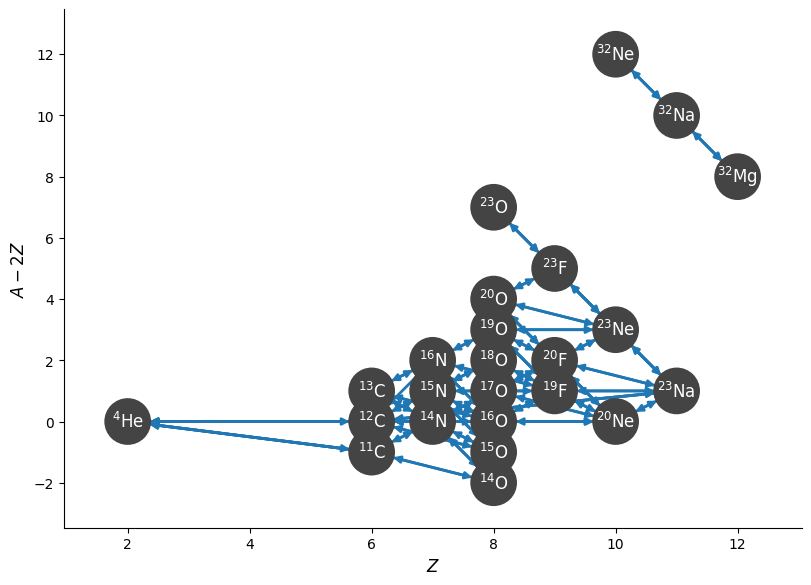

In [28]:
fig = reduced_net2.plot(rotated=True, hide_xalpha=True)

In [ ]:
enuc_reference